In [1]:
from pathlib import Path
import pandas as pd
from etna.datasets.tsdataset import TSDataset


/home/fropych/anaconda3/envs/env/lib/python3.10/site-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/home/fropych/anaconda3/envs/env/lib/python3.10/site-packages/etna/settings.py:53: UserWarning: etna[prophet] is not available, to install it, run `pip install etna[prophet]`
  warnings.warn("etna[prophet] is not available, to install it, run `pip install etna[prophet]`")
/home/fropych/anaconda3/envs/env/lib/python3.10/site-packages/etna/settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")


In [2]:
PATH = "reinforcement_task/data/"

In [3]:
list(Path(PATH).iterdir())


[PosixPath('reinforcement_task/data/Цены на сырье.xlsx'),
 PosixPath('reinforcement_task/data/train_merged.csv'),
 PosixPath('reinforcement_task/data/train.xlsx'),
 PosixPath('reinforcement_task/data/Индекс LME.xlsx'),
 PosixPath('reinforcement_task/data/CHMF Акции.csv'),
 PosixPath('reinforcement_task/data/test.xlsx'),
 PosixPath('reinforcement_task/data/Показатели рынка металла.xlsx'),
 PosixPath('reinforcement_task/data/train_metall.csv'),
 PosixPath('reinforcement_task/data/MAGN Акции.csv'),
 PosixPath('reinforcement_task/data/NLMK Акции.csv'),
 PosixPath('reinforcement_task/data/test_fixed.csv'),
 PosixPath('reinforcement_task/data/Грузоперевозки.xlsx'),
 PosixPath('reinforcement_task/data/Макропоказатели.xlsx'),
 PosixPath('reinforcement_task/data/train_with_actions.csv'),
 PosixPath('reinforcement_task/data/train_actions_building_materials.csv'),
 PosixPath('reinforcement_task/data/Топливо.xlsx'),
 PosixPath('reinforcement_task/data/Данные рынка стройматериалов.xlsx')]

In [4]:
features_train_df = pd.read_csv(PATH + "train_merged.csv")
features_test_df = pd.read_csv(PATH + "test_fixed.csv")


In [5]:
features_train_df = features_train_df.rename(
    columns={
        "Date": "timestamp",
    }
)
features_train_df["segment"] = 1
features_train_df["timestamp"] = pd.to_datetime(features_train_df["timestamp"])


features_test_df = features_test_df.rename(
    columns={
        "Date": "timestamp",
    }
)
features_test_df["segment"] = 1
features_test_df["timestamp"] = pd.to_datetime(features_test_df["timestamp"])

In [6]:
to_drop = (features_train_df.isna().sum() > 230)

features_train_df = features_train_df.drop(to_drop[to_drop==True].index.values, axis=1)
features_train_df = features_train_df.drop(['Unnamed: 0', 'Цена на арматуру', 'dt'], axis=1)

features_test_df = features_test_df.drop(to_drop[to_drop==True].index.values, axis=1)
features_test_df = features_test_df.drop(['Цена на арматуру'], axis=1)

In [7]:
train_df = pd.read_excel(PATH + "train.xlsx")
test_df = pd.read_excel(PATH + "test.xlsx")

def get_ts(df, features_df):
    df = df.rename(
    columns={
        "dt": "timestamp",
        "Цена на арматуру": "target",
    }
    )
    df["segment"] = 1
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    ts = TSDataset.to_dataset(df[["timestamp", "target", "segment"]])
    features = TSDataset.to_dataset(features_df)
    ts = TSDataset(ts, freq="W-MON",
                # df_exog=features
                )
    
    return ts

train_ts = get_ts(train_df, features_train_df)
test_ts = get_ts(test_df, features_test_df)

In [8]:
from etna.models import (
    SeasonalMovingAverageModel,
    LinearPerSegmentModel,
    CatBoostPerSegmentModel,
    AutoARIMAModel,
)

# from etna.models.nn import RNNModel
from etna.pipeline import Pipeline, AutoRegressivePipeline
from etna.metrics import SMAPE, MAPE
from etna.transforms import (
    DensityOutliersTransform,
    LogTransform,
    TimeSeriesImputerTransform,
    LagTransform,
    DateFlagsTransform,
    HolidayTransform,
    MeanTransform,
    DifferencingTransform,
    FourierTransform,
    LinearTrendTransform,
    MADTransform,
    MaxAbsScalerTransform,
    MaxTransform,
    MedianTransform,
    MinMaxDifferenceTransform,
    MinMaxScalerTransform,
    MinTransform,
    StdTransform,
    FilterFeaturesTransform,
    TreeFeatureSelectionTransform, 
    MRMRFeatureSelectionTransform,
    STLTransform
)

In [9]:
HORIZON = 1
transforms = [
    FourierTransform(order=2, period=5, out_column="fourier"),
    DifferencingTransform(
        in_column="target", order=10, period=1, out_column="differencing", inplace=False
    ),
    DateFlagsTransform(
        out_column="d_flags",
        week_number_in_month=True,
        #  week_number_in_year=True,
        #  month_number_in_year=True,
        season_number=True,
        year_number=True,
        is_weekend=False,
        #  special_days_in_week=[4],
        # is_weekend=False,
        # day_number_in_month=False,
        day_number_in_year=True
    ),
    LagTransform(
        in_column="target",
        lags=list(range(HORIZON, HORIZON + 20)),
        out_column="regressor_lag",
    ),
    MeanTransform(
        in_column="target", out_column="regressor_mean", window=5, seasonality=1
    ),
    MaxTransform(
        in_column="target", out_column="regressor_max", window=5, seasonality=1
    ),
    LagTransform(
        in_column="regressor_max",
        lags=list(range(HORIZON, HORIZON + 5)),
        out_column="regressor_max_lag",
    ),
    LagTransform(
        in_column="regressor_mean",
        lags=list(range(HORIZON, HORIZON + 5)),
        out_column="regressor_mean_lag",
    ),
    # STLTransform(in_column="target",period=52),
    ### Чугун
    # LagTransform(
    #     in_column='Чугун_FOB Россия Черное море, $/т',
    #     lags=list(range(HORIZON, HORIZON + 20)),
    #     out_column="Чугун_lag",
    # ),
    # MeanTransform(
    #     in_column="Чугун_FOB Россия Черное море, $/т", out_column="Чугун_mean", window=5, seasonality=1
    # ),
    # MaxTransform(
    #     in_column="Чугун_FOB Россия Черное море, $/т", out_column="Чугун_max", window=5, seasonality=1
    # ),
    # LagTransform(
    #     in_column="Чугун_max",
    #     lags=list(range(HORIZON, HORIZON + 5)),
    #     out_column="Чугун_max_lag",
    # ),
    # LagTransform(
    #     in_column="Чугун_mean",
    #     lags=list(range(HORIZON, HORIZON + 5)),
    #     out_column="Чугун_mean_lag",
    # ),
    # ### Лом
    # LagTransform(
    #     in_column='Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС',
    #     lags=list(range(HORIZON, HORIZON + 20)),
    #     out_column="Лом_lag",
    # ),
    # MeanTransform(
    #     in_column='Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС', out_column="Лом_mean", window=5, seasonality=1
    # ),
    # MaxTransform(
    #     in_column='Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС', out_column="Лом_max", window=5, seasonality=1
    # ),
    # LagTransform(
    #     in_column="Лом_max",
    #     lags=list(range(HORIZON, HORIZON + 5)),
    #     out_column="Лом_max_lag",
    # ),
    # LagTransform(
    #     in_column="Лом_mean",
    #     lags=list(range(HORIZON, HORIZON + 5)),
    #     out_column="Лом_mean_lag",
    # ),
    # TreeFeatureSelectionTransform(model='catboost', top_k=50)
    # TimeSeriesImputerTransform(
    #     in_column="target", strategy="running_mean", window=4
    # ),
]

In [10]:
import warnings
warnings.filterwarnings("ignore")

## Feature Relevance

In [11]:
# from etna.analysis import plot_feature_relevance, ModelRelevanceTable
# from catboost import CatBoostRegressor

# ts.fit_transform(transforms)
# top_f = plot_feature_relevance(
#     ts=ts,
#     relevance_table=ModelRelevanceTable(),
#     relevance_aggregation_mode="mean",
#     relevance_params={
#         "model": CatBoostRegressor(
#             verbose=0,
#             cat_features=[
#                 "d_flags_day_number_in_month",
#                 "d_flags_day_number_in_week",
#                 # "d_flags_is_weekend",
#                 "d_flags_year_number",
#                 "d_flags_season_number",
#                 "d_flags_week_number_in_month",
#             ],
#         )
#     },
#     top_k=50,
#     figsize=(20, 10)
# )

In [12]:
# top_f

## Validation

In [13]:
model = LinearPerSegmentModel()


pipe = AutoRegressivePipeline(model=model, transforms=transforms, horizon=10, step=1)
smape = MAPE()
# metrics, forecast, info = pipe.backtest(ts=train_ts, metrics=[smape], n_folds=10, n_jobs=1)

In [14]:
from copy import deepcopy


model2 = CatBoostPerSegmentModel()


pipe2 = AutoRegressivePipeline(model=model2, transforms=deepcopy(transforms), horizon=10, step=1)
smape = MAPE()

In [15]:
from etna.ensembles import VotingEnsemble

In [16]:
ensemble = VotingEnsemble(
    pipelines=[pipe, pipe2],
    weights=[0.5, 0.5]
)

metrics, forecast, info = ensemble.backtest(ts=train_ts, metrics=[smape], n_folds=10, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    

In [17]:
metrics.MAPE.mean(), metrics.MAPE.std()

(13.361547636806568, 9.118927493612643)

In [18]:
1/0

ZeroDivisionError: division by zero

## Optuna

In [ ]:
# pipe.params_to_tune()

In [ ]:
# from etna.auto import Tune


# tune = Tune(pipeline=pipe, target_metric=MAPE(), horizon=HORIZON, backtest_params=dict(n_folds=10))
# best_pipeline = tune.fit(ts=ts, n_trials=20)

In [ ]:
# best_pipe = tune.summary().sort_values('MAPE_mean').iloc[0]['pipeline']

In [ ]:
# best_pipe.to_dict()

### Проверка optun'ы

In [ ]:
# metrics, forecast, info = best_pipe.backtest(ts=ts, metrics=[smape], n_folds=10, n_jobs=1)

In [ ]:
# metrics.MAPE.mean(), metrics.MAPE.std()

## Train

In [19]:
pipe = ensemble.fit(train_ts)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s finished


In [ ]:
pipe.save("pipeline.zip")

## Predict

In [ ]:
pipe.horizon

10

In [ ]:
# from etna.core import load
# pipe = load('pipeline.zip', ts=test_ts)

In [ ]:
# preds = pipe.predict(train_ts, start_timestamp=pd.Timestamp('2022-09-05'), end_timestamp=pd.Timestamp('2023-03-13'))

In [20]:
pipe.horizon = 28

for p in ensemble.pipelines:
    p.horizon=28

preds = pipe.forecast(train_ts)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s finished


In [ ]:
# preds2 = pipe.forecast(preds)

In [21]:
from etna.analysis import plot_forecast

In [23]:
preds.loc[:, '1']['target'].to_csv('test_preds.csv', index=False)

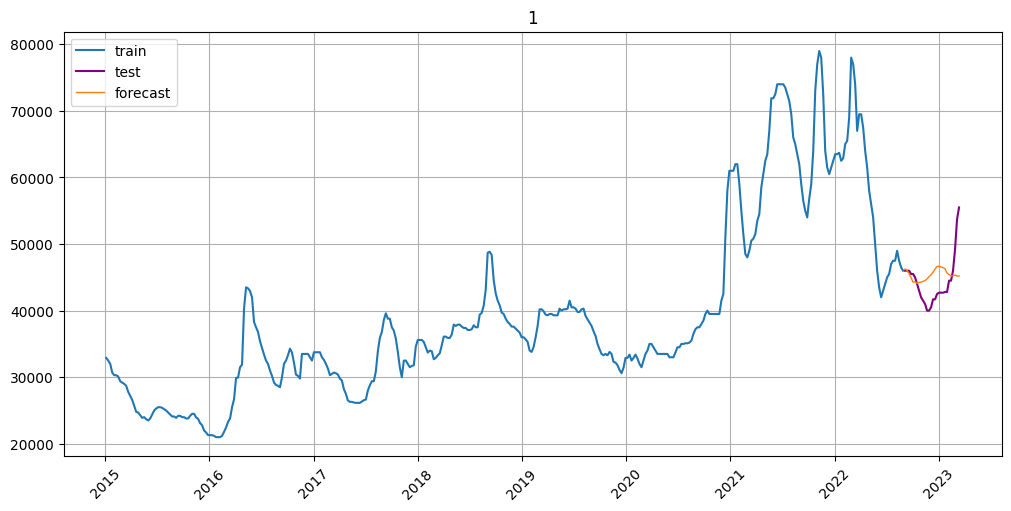

In [22]:
plot_forecast(preds, test_ts, train_ts)

## Графики

In [ ]:
# ts.plot(column="Экспорт сырья Металлизованная продукция_ГБЖ")


In [ ]:
ts.plot(column='ГБЖ_Россия, FCA руб./т, без НДС')


NameError: name 'ts' is not defined

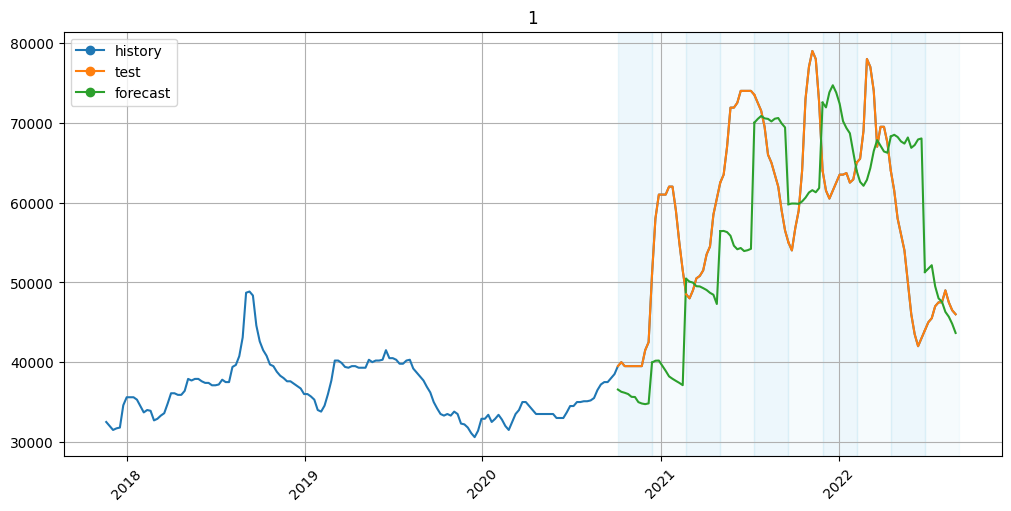

In [ ]:
from etna.analysis import plot_backtest

plot_backtest(forecast_df=forecast, ts=train_ts, history_len=150)
